In [53]:
# Loading dependencies.
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import linregress
import requests
import time
import hvplot.pandas


In [2]:
# Path to csv.
card_fraud_path_load = Path("resource/credit_card_fraud.csv")
card_data = pd.read_csv(card_fraud_path_load)
card_data.head()

,Transaction Date and Time,Transaction Amount,Cardholder Name,Card Number (Hashed or Encrypted),Merchant Name,Merchant Category Code (MCC),Transaction Location (City or ZIP Code),Transaction Currency,Card Type,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Transaction ID,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,2022-09-24 13:54:27,285.88,Shray Soman,daca51bffe0fc4eaaa7c430917f94b75fd893712492254...,"Rajagopalan, Ghose and Kant",3590,Khammam,INR,MasterCard,04/29,01299ac65733b5a3d774265fbfe8396b8611e5e3321855...,5,b7f69cbc-a03d-41f8-adca-75920b0242c3,1,NaN,Online,18.106.240.6,Tablet,NaN,Consequatur corporis minima ad vero deserunt n...
1,2020-07-24 11:20:13,1777.32,Lakshit Bakshi,d5366dd9be3a0266c0252baceaa6332210ed4dbd0ef252...,Sule PLC,7277,Vasai-Virar,EUR,American Express,03/26,ad8fa913d25b3970c6efa8ca504da8ba670ce2a9cf012d...,12,ad53cc8e-8412-422e-8cad-4176daac8387,1,NaN,Online,212.48.185.128,Mobile,jloyal,Dolore repellendus odio deleniti. Eaque quibus...
2,2023-03-18 01:05:36,3939.01,Riya Bobal,4737a6384aa1c3c31f7768b86633d6a8401dd6ab4a8ff1...,Badal PLC,9297,Nangloi Jat,USD,Visa,11/29,eb3be230bbd2844b1f5d8f2e4fab9ffba8ab22cfeeb69c...,5,f09cecd6-0d74-4551-8089-a31d64e6b9c5,1,3 or more,In-Person,17.190.112.46,Mobile,NaN,Unde beatae perspiciatis sapiente. Voluptates ...
3,2021-01-07 21:53:04,376.44,Mohanlal Balakrishnan,4721806eed8f2663bb597ff13e79a294de318358fbb54b...,Konda-Sodhi,5686,Ramagundam,USD,Visa,09/25,891d46993a36d78392247c642138cede01d9841daab1d9...,5,b208ae0b-4c4f-428f-b6b9-5360b288b947,0,2,In-Person,153.136.24.104,Tablet,NaN,Cupiditate repellendus necessitatibus quo occa...
4,2021-12-16 06:22:24,1687.33,Mannat Rout,9deacc3a9efd6e382826d400620aca5f23ed94327578e5...,Dua Ltd,2940,Adoni,INR,MasterCard,03/31,48a1a756f2d83f1dc57bbf14052b70a6f40d0fceed6662...,5,6b4e4e43-5b73-4906-9973-299a1b2a5e71,1,2,Online,196.153.28.131,Desktop,NaN,Molestias assumenda consectetur itaque veritat...


In [3]:
# General info on data.
card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Transaction Date and Time                8000 non-null   object 
 1   Transaction Amount                       8000 non-null   float64
 2   Cardholder Name                          8000 non-null   object 
 3   Card Number (Hashed or Encrypted)        8000 non-null   object 
 4   Merchant Name                            8000 non-null   object 
 5   Merchant Category Code (MCC)             8000 non-null   int64  
 6   Transaction Location (City or ZIP Code)  8000 non-null   object 
 7   Transaction Currency                     8000 non-null   object 
 8   Card Type                                8000 non-null   object 
 9   Card Expiration Date                     8000 non-null   object 
 10  CVV Code (Hashed or Encrypted)           8000 no

In [35]:
# Counted how many (potential) fraud or valid transactions there are in the data.
fraud_data_row = card_data[card_data['Fraud Flag or Label'] == 1]
fraud_data_count = len(fraud_data_row)
valid_data_row = card_data[card_data['Fraud Flag or Label'] == 0]
valid_data_count = len(valid_data_row)
print(f"There are {fraud_data_count} fraud or flag or labeled transactions in the dataset.")
print(f"There are {valid_data_count} valid transactions in the dataset.")

There are 3989 fraud or flag or labeled transactions in the dataset.
There are 4011 valid transactions in the dataset.


In [6]:
card_data['Transaction Date and Time'].isnull().sum()

0

In [36]:
# Formatted the column into a date form.
card_data_transaction_date = pd.to_datetime(card_data['Transaction Date and Time'], format = '%m-%d-%Y %H:%M:%S')
card_data_expiration_date = pd.to_datetime(card_data['Card Expiration Date'], format='%m/%y')

card_data_transaction_date.head()

0   2022-09-24 13:54:27
1   2020-07-24 11:20:13
2   2023-03-18 01:05:36
3   2021-01-07 21:53:04
4   2021-12-16 06:22:24
Name: Transaction Date and Time, dtype: datetime64[ns]

In [38]:

card_data_transaction_year = card_data_transaction_date.dt.year
card_data_transaction_month = card_data_transaction_date.dt.month
card_data_transaction_day = card_data_transaction_date.dt.day

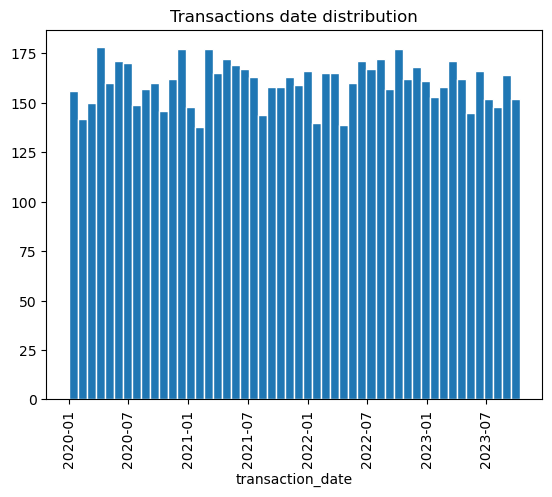

In [39]:
# Histogram for transaction date distribution.
plt.hist(card_data_transaction_date, bins=50, edgecolor='white')
plt.title("Transactions date distribution")
plt.xlabel("transaction_date")
plt.xticks(rotation=90, ha='center')
plt.show()


In [70]:
transactions_per_year = card_data.groupby(card_data_transaction_year).size()
transactions_per_year = transactions_per_year.reset_index()
transactions_per_year.columns = ['Year', 'Transaction per year']
transactions_per_year



,Year,Transaction per year
0,2020,2114
1,2021,2137
2,2022,2134
3,2023,1615


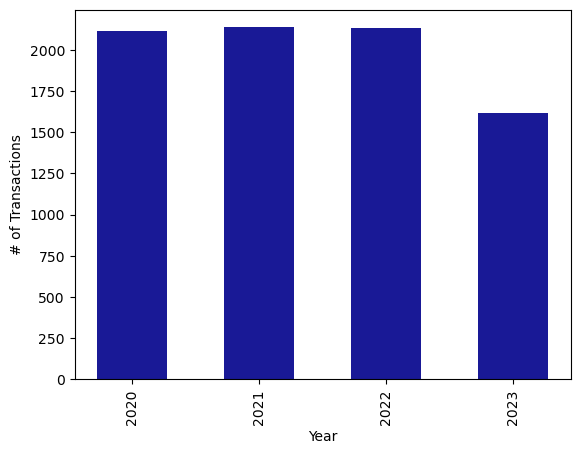

In [71]:
x_axis = transactions_per_year['Year']
y_axis = transactions_per_year['Transaction per year']

tick_locations = []

for x in x_axis:
    tick_locations.append(x)

plt.bar(x_axis, y_axis, color="darkblue", alpha=0.9, align="center", width=0.55)
plt.xticks(tick_locations, rotation=90, ha='center')
plt.xlabel("Year")
plt.ylabel("# of Transactions")
plt.show()


In [73]:
transactions_per_month = card_data.groupby(card_data_transaction_month).size()
transactions_per_month = transactions_per_month.reset_index()
transactions_per_month.columns = ['Month', 'Transactions per month']
transactions_per_month

,Month,Transactions per month
0,1,672
1,2,634
2,3,747
3,4,670
4,5,743
5,6,721
6,7,710
7,8,710
8,9,721
9,10,569


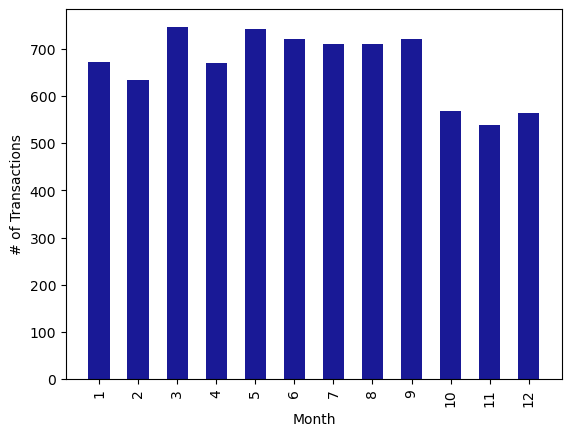

In [77]:
x_axis = transactions_per_month['Month']
y_axis = transactions_per_month['Transactions per month']

tick_locations = []

for x in x_axis:
    tick_locations.append(x)

plt.bar(x_axis, y_axis, color="darkblue", alpha=0.9, align="center", width=0.55)
plt.xticks(tick_locations, rotation=90, ha='center')
plt.xlabel("Month")
plt.ylabel("# of Transactions")
plt.show()